In [3]:
# import required libraries
import numpy as np
from brian2 import *
import pylab

# allows plotting inline

%matplotlib inline 

# Contents

## 1. Neuron and Synapse Models
    1.1 NeuronGroups and Synapses
    1.2 Parameters of Neurons and Synapses
## 2. Network Connections
    2.1 CA3 to CA1 Connectivity
    2.2 EC3 to CA1 Connectivity
    2.3 CA1 local inhibition
    2.4 NR induced CA1 inhibition
## 3. Training
    3.1 EC3 Input Pattern (Experimental Condition)
    3.2 CA3 Input Pattern (Experimental Condition)
    3.3 NR Input
    3.4 Lesions (Experimental Condition)
    3.5 Run Simulation
    3.6 Save Experimental Conditions and Results
    
## 4. Testing
    4.1 Lesions (Experimental Condition)
    4.2 Present Saved Pattern
    4.3 Save Results
    4.4 Plot Results

# 1. Neuron and Synapse Models

## 1.1 NeuronGroups and Synapses
* There are 5 different neuron types and 3 different synapses

### - Inhibitory CA1 Neuron

In [10]:
# here are the equations defining the neuron model

CA1_OLM_eqs = '''
dv/dt = ((k_low*(mV/nS)*(v_a*(v**2) + v_b*(v) + v_c))*pF/C - u/C + I/C ) : volt
du/dt = a*(((b)*(v - v_r*mV)) - u) : amp
I = CA1_OLM_input(t): amp
''' 
  
CA1_OLM_post_spike = '''
v = c
u += d
'''

# this generates a neurongroup with neurons that follow the above equations.
CA1_OLM = NeuronGroup(1, CA1_OLM_eqs, threshold='v>CA1_OLM_theta_reset', reset = CA1_OLM_post_spike) #threshold in this model is the peak threshold

### - CA1 Pyramidal Cell

* This includes the NMDA and AMPA synapses on the pyramidal cells.
* Perhaps it would make sense to separate the synapses from the Pyramidal cell model

In [12]:
CA1_eqs = '''
dv/dt = ((k*(mV/nS)*(v_a*(v**2) + v_b*(v) + v_c))*pF/C - u/C +   
I_shift/C - I_syn_distal/C  - I_syn_proximal/C - I_GABA/C ): volt

du/dt = a*(((b)*(v - v_r*mV)) - u) : amp
k = (v<(-57.0 * mV))*k_low+(v>=(-57.0 *mV))*k_high : siemens/volt


I_syn_distal = g_syn_EC3*(v - E_syn): amp
I_syn_proximal = g_syn_CA3*(v - E_syn): amp
dg_syn_CA3/dt = -g_syn_CA3 / tau_decay_CA3 : siemens
dg_syn_EC3/dt = -g_syn_EC3 / tau_decay_EC3 : siemens

NMDA_g_syn = gbar_syn * f * g : siemens 
dg/dt = -g/tau_decay + h*becquerel : 1 
dh/dt = -h/tau_rise  + 1*(becquerel) : 1 
tpeak = (tau_decay * tau_rise)/(tau_decay - tau_rise) * log(tau_decay/tau_rise) : second (constant over dt)
f = (tau_decay - tau_rise)/(tau_rise*tau_decay*(-exp(-tpeak/tau_rise) + exp(-tpeak/tau_decay)))/becquerel : 1 (constant over dt)
h0 = 1 : 1


I_NMDA = NMDA_g_syn * (1/(1+exp(-a*v)/3.57))*(v - E_syn): amp

I_GABA = g_GABA*(v - E_GABA): amp
dg_GABA/dt = -g_GABA / tau_GABA : siemens


'''

CA1_post_spike = '''
v = c
u += d
'''


CA1_post_action= '''
g_syn_EC3 += EC3_g_jump*w
h += 1


''' # give this step a more meaningful description

on_post_LTP = '''

w += n*(Omega_post - w)
'''

CA1 = NeuronGroup(100, CA1_eqs, threshold='v>CA1_theta_reset', reset = CA1_post_spike)

### - CA3 Pyramidal Cell

In [14]:

CA3_p_eqs = '''
dv/dt = ((k_low*(mV/nS)*(v_a*(v**2) + v_b*(v) + v_c))*pF/C - u/C + I/C ) : volt
du/dt = a*(((b)*(v - v_r*mV)) - u) : amp
I = CA3_input(t,i): amp
''' 
  
CA3_post_spike = '''
v = c
u += d
'''

CA3 = NeuronGroup(100, CA3_p_eqs, threshold='v>CA3_theta_reset', reset = CA3_post_spike) #threshold in this model is the peak threshold



### - EC3 Pyramidal Cell

In [15]:
EC3_p_eqs = '''
dv/dt = ((k*(mV/nS)*(v_a*(v**2) + v_b*(v) +v_c))*pF/C - u/C + I/C  ) : volt
du/dt = a*((b*(v - v_r *mV) - u)) : amp
I = EC3_input(t,i): amp
k = (v<(-56.9 * mV))*k_low+(v>=(-56.9 *mV))*k_high : siemens/volt
''' 

EC3_post_spike = '''
v = c
u += d
'''



EC3 = NeuronGroup(100, EC3_p_eqs, threshold='v>EC3_theta_reset', reset = EC3_post_spike) #threshold in this model is the peak threshold


### - NR Relay Cell

In [16]:
NR_eqs = '''
dv/dt = ((k*(mV/nS)*(v_a*(v**2) + v_b*(v) +v_c))*pF/C - u/C + I/C  ) : volt
du/dt = a*((b*(v - v_r *mV) - u)) : amp
I = EC3_input(t,i): amp

''' 

NR_post_spike = '''
v = c
u += d
'''


NR = NeuronGroup(1, NR_eqs, threshold='v>NR_theta_reset', reset = NR_post_spike) #threshold in this model is the peak threshold


### - EC3 Pyramidal to CA1 Pyramidal synapse

In [ ]:
EC3_CA1_model = '''

dCa/dt = (-I_NMDA_post/amp - second*(1/(50*ms))*Ca)/second: 1
Omega = .25 + (exp(B_2*((Ca/(1e-11))-alpha_2))/(1+exp(B_2*((Ca/(1e-11))-alpha_2)))) - ((.25*exp(B_1*((Ca/(1e-11))-alpha_1)))/(1+exp(B_1*((Ca/(1e-11))-alpha_1)))): 1

tau_n = P1/((P1/(1e4)) + (Ca/(1e-11))**3) + 1 :1

n = 1/tau_n: 1

dw/dt = n*(Omega-w)/second:1 (clock-driven)



'''

EC3_CA1 = Synapses( EC3,CA1,EC3_CA1_model, on_pre = CA1_post_action,  delay = .1*ms, dt=1*ms) #on_post= on_post_LTP,


### - CA1 Local Inhibitory to CA1 Pyramidal Synapse

In [ ]:
CA1_GABA = Synapses( CA1_OLM,CA1, on_pre = 'g_GABA += GABA_jump')

### - CA3 Pyramidal to CA1 Pyramidal Synapse

In [ ]:
CA3_CA1 = Synapses( CA3,CA1,'w:1', on_pre ='g_syn_CA3 += CA3_g_jump*w')

### - CA1 Pyramidal to CA1 Local Inhibitory Synapse


### - NR Relay to CA1 Distal Inhibitory Synapse

### - CA1 Distal Inhibitory Synapse to CA1 Pyramidals

# 1.2 Parameters of Models

## - EC3 pyramidal neuron 

In [19]:


# EC3 pyramidal neuron parameters.  
EC3.namespace['a'] = .00001/ms
EC3.namespace['b'] = 1 * nsiemens
EC3.namespace['c'] = -74.153 *mV
EC3.namespace['d'] = .5 *pA #I think I shoudl use pico amps for this.. seriously 
EC3.namespace['theta_reset'] = 7.7 * mV # this is v_peak. There is no such thing as a firing threshold. 
EC3.namespace['v_r'] = -70.9 # mV
EC3.namespace['v_t'] = -56.9 # mV 
EC3.namespace['C'] = 500 * pF
EC3.namespace['k_low'] = .6 * nsiemens/mV
EC3.namespace['k_high'] = 8 * nsiemens/mV
#EC3_I_shift = -35 *pA

#the quadratic terms based on v_r and v_t
EC3.namespace['v_a'] = 1   /(ms*mV)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  #/(ms*mV)
EC3.namespace['v_b'] = -1*(EC3.namespace['v_r'] + EC3.namespace['v_t']) /ms#/ms
EC3.namespace['v_c'] = (EC3.namespace['v_r'] * EC3.namespace['v_t']) *(mV/ms)#*mV/ms 
# Standard Izhikevich neuron equations.  
EC3.v = -70.9 *mV

## - CA3 Pyramidal Cell


In [20]:
CA3.namespace['a'] = 0.0023 /ms
CA3.namespace['b'] = 3.428  * nsiemens
CA3.namespace['c'] = -47.77 *mV
CA3.namespace['d'] = 112   *pA #I think I shoudl use pico amps for this.. seriously 
CA3.namespace['theta_reset'] = 2 * mV # this is v_peak. There is no such thing as a firing threshold. 
CA3.namespace['v_r'] = -56.777  # mV
CA3.namespace['v_t'] = -36.777 # mV 
CA3.namespace['C'] = 589 * pF
CA3.namespace['k_low'] = 2.571* nsiemens/mV

#the quadratic terms based on v_r and v_t
CA3.namespace['v_a'] = 1   /(ms*mV)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  #/(ms*mV)
CA3.namespace['v_b'] = -1*(CA3.namespace['v_r'] + CA3.namespace['v_t']) /ms#/ms
CA3.namespace['v_c'] = (CA3.namespace['v_r'] * CA3.namespace['v_t']) *(mV/ms)#*mV/ms 
# Standard Izhikevich neuron equations.  
CA3.v = -56.77 *mV

## - CA1 Inhibitory Cell

In [ ]:
CA1_OLM.namespace['CA1_OLM_k_low'] = .527* nsiemens/mV


CA1_OLM.namespace['a'] = 0.00223 /ms
CA1_OLM.namespace['b'] = 6.15  * nsiemens
CA1_OLM.namespace['c'] = -44.97 *mV
CA1_OLM.namespace['d'] = -12   *pA #I think I shoudl use pico amps for this.. seriously 
CA1_OLM.namespace['theta_reset'] = 81.81 * mV # this is v_peak. There is no such thing as a firing threshold. 
CA1_OLM.namespace['v_r'] = -57.25  # mV
CA1_OLM.namespace['v_t'] = -42.78 # mV 
CA1_OLM.namespace['C'] = 253 * pF


#the quadratic terms based on v_r and v_t
CA1_OLM.namespace['v_a'] = 1   /(ms*mV)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  #/(ms*mV)
CA1_OLM.namespace['v_b'] = -1*(CA1_OLM.namespace['v_r'] + CA1_OLM.namespace['v_t']) /ms#/ms
CA1_OLM.namespace['v_c'] = (CA1_OLM.namespace['v_r'] * CA1_OLM.namespace['v_t']) *(mV/ms)#*mV/ms 
# Standard Izhikevich neuron equations.  

## - CA1 Pyramidal Cell


* The first weakly adapting model from Ferguson (2015)
* V<sub>r</sub> =  -61.8 mV
* V<sub>t</sub> =  -57.0 mV
* c = -65.8mV
* d = 5  pA 
* a = 0.001/ms
* b = 3 * nsiemens
* V<sub>peak</sub> =  22.6 mV
* k<sub>low</sub> = .5 nS/mV 
* k<sub>high</sub> =  3.3 nS/mV
* I<sub>shift</sub> = -45 pA

In [21]:
# CA1 pyramidal neuron parameters.  
CA1.namespace['a'] = 0.001/ms
CA1.namespace['b'] = 3 * nsiemens
CA1.namespace['c'] = -65.8 *mV
CA1.namespace['d'] = 5  *pA #I think I shoudl use pico amps for this.. seriously 
CA1.namespace['theta_reset'] = 22.6 * mV # this is v_peak. There is no such thing as a firing threshold. 
CA1.namespace['v_r'] = -61.8 # mV
CA1.namespace['v_t'] = -57.0 # mV 
CA1.namespace['C'] = 300 * pF
CA1.namespace['k_low'] = .5 * nsiemens/mV
CA1.namespace['k_high'] = 3.3 * nsiemens/mV

CA1.namespace['I_shift'] = -45 *pA

# channel stuff
CA1.namespace['E_syn'] = 0 *mV # the equilibrium potential of the synapse
CA1.namespace['tau_decay'] = 2 *ms
CA1.namespace['g_jump'] = 10*nS

#the quadratic terms based on v_r and v_t
CA1.namespace['v_a'] = 1   /(ms*mV)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  #/(ms*mV)
CA1.namespace['v_b'] = -1*(CA1.namespace['v_r'] + CA1.namespace['v_t']) /ms#/ms
CA1.namespace['v_c'] = (CA1.namespace['v_r'] * CA1.namespace['v_t']) *(mV/ms)#*mV/ms 

## - NR Relay Cell

* I guess this cell doesn't have any adaptation, according to izhikevich textbook

In [22]:
NR.namespace['a'] = 0/ms
NR.namespace['b'] = 0*nsiemens
NR.namespace['c'] = -60*mV
NR.namespace['d'] = 0 *pA
NR.namespace['theta_reset'] = 35 *mV
NR.namespace['v_r'] = -60*mV
NR.namespace['v_t'] = -50*mV
NR.namespace['C'] = 200*pF
NR.namespace['k'] = 1.6 *nsiemens/mV

NR.namespace['v_a'] = 1   /(ms*mV)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  #/(ms*mV)
NR.namespace['v_b'] = -1*(NR.namespace['v_r'] + NR.namespace['v_t']) /ms#/ms
NR.namespace['v_c'] = (NR.namespace['v_r'] * NR.namespace['v_t']) *(mV/ms)#*mV/ms 

## Create Synapses on CA1 neuron

In [165]:
# properties of the synapse

E_GABA = -70 * mV # equilibrium potential of the channel
tau_GABA = 6 * ms # speed of NT unbinding
GABA_jump = 10*nsiemens
E_syn = 0 *mV # the equilibrium potential of the synapse
tau_decay_CA3 = 5 *ms
tau_decay_EC3 = 5 *ms
EC3_g_jump = 1.69*nS #  this is supposed to be an ampa channel
CA3_g_jump = 10*nS

B_2 = 80
B_1 = 80
alpha_2 = .85#.25
alpha_1 = .65#.05



a = .062/mV
gbar_syn = .00000001*siemens 
tau_rise = 2 *ms 
tau_decay = 50 *ms
P1 = 3


# Change CA1 model to include synaptic current Isyn and exclude constant DC input
CA1_eqs_synapse = '''
dv/dt = ((k*(mV/nS)*(CA1_v_a*(v**2) + CA1_v_b*(v) + CA1_v_c))*pF/CA1_C - u/CA1_C +   
CA1_I_shift/CA1_C - I_syn_distal/CA1_C  - I_syn_proximal/CA1_C - I_GABA/CA1_C ): volt

du/dt = CA1_a*(((CA1_b)*(v - CA1_v_r*mV)) - u) : amp
k = (v<(-57.0 * mV))*CA1_k_low+(v>=(-57.0 *mV))*CA1_k_high : siemens/volt


I_syn_distal = g_syn_EC3*(v - E_syn): amp
I_syn_proximal = g_syn_CA3*(v - E_syn): amp
dg_syn_CA3/dt = -g_syn_CA3 / tau_decay_CA3 : siemens
dg_syn_EC3/dt = -g_syn_EC3 / tau_decay_EC3 : siemens

NMDA_g_syn = gbar_syn * f * g : siemens 
dg/dt = -g/tau_decay + h*becquerel : 1 
dh/dt = -h/tau_rise  + 1*(becquerel) : 1 
tpeak = (tau_decay * tau_rise)/(tau_decay - tau_rise) * log(tau_decay/tau_rise) : second (constant over dt)
f = (tau_decay - tau_rise)/(tau_rise*tau_decay*(-exp(-tpeak/tau_rise) + exp(-tpeak/tau_decay)))/becquerel : 1 (constant over dt)
h0 = 1 : 1


I_NMDA = NMDA_g_syn * (1/(1+exp(-a*v)/3.57))*(v - E_syn): amp

I_GABA = g_GABA*(v - E_GABA): amp
dg_GABA/dt = -g_GABA / tau_GABA : siemens


'''

EC3_CA1_model = '''

dCa/dt = (-I_NMDA_post/amp - second*(1/(50*ms))*Ca)/second: 1
Omega = .25 + (exp(B_2*((Ca/(1e-11))-alpha_2))/(1+exp(B_2*((Ca/(1e-11))-alpha_2)))) - ((.25*exp(B_1*((Ca/(1e-11))-alpha_1)))/(1+exp(B_1*((Ca/(1e-11))-alpha_1)))): 1

tau_n = P1/((P1/(1e4)) + (Ca/(1e-11))**3) + 1 :1

n = 1/tau_n: 1

dw/dt = n*(Omega-w)/second:1 (clock-driven)



'''

CA1_post_action= '''
g_syn_EC3 += EC3_g_jump*w
h += 1


''' # give this step a more meaningful description

on_post_LTP = '''

w += n*(Omega_post - w)
'''

CA1 = NeuronGroup(CA1_size, CA1_eqs_synapse, threshold='v>CA1_theta_reset', reset = CA1_post_spike)
CA1.v = -61.8 * mV

EC3_CA1 = Synapses( EC3,CA1,EC3_CA1_model, on_pre = CA1_post_action,  delay = .1*ms, dt=1*ms) #on_post= on_post_LTP,
CA3_CA1 = Synapses( CA3,CA1,'w:1', on_pre ='g_syn_CA3 += CA3_g_jump*w')
#EC3_CA1.connect(j='i')

#EC3_CA1_spikes = SpikeMonitor(EC3_CA1, variables=('w'))


## 1.2 Model Parameters

In [166]:




CA1_OLM.v = -57.25 *mV

CA1_GABA = Synapses( CA1_OLM,CA1, on_pre = 'g_GABA += GABA_jump')

I_NMDA = NMDA_g_syn * (1/(1+exp(-a*v)/3.57))*(v - E_syn): amp
dCa/dt = (I_NMDA/amp - second*(1/(50*ms))*Ca)/second: 1
Omega = .25 + exp(B_2*(Ca-alpha_2))*(1+exp(B_2*alpha_2)) - .25*exp(B_1*(Ca-alpha_1))*(1+exp(B_1*alpha_1)): 1
dw/dt = w + (Omega_post-w):1 (event-driven)






## Connect CA3 to CA1 +  Connect EC3 to CA1 + Connect Inhibitory CA1 to CA1 Pyramidals

* In the random version of the model, these connections will be random, with a given probability
* Specifically, connections from EC3 to CA1 will be random
* Connections from CA3 to CA1 will also be random
* For now, 1 inhibitory neuron will be connected to all CA1 neurons

In [167]:

EC3_CA1.connect(condition = 'abs(i-j)<8') # random all to all connections #i=np.arange(0,100,1), j=np.arange(0,100,1)) # 

CA3_CA1.connect( condition = 'abs(i-j)<3')#i=np.arange(0,100,1), j=np.arange(0,100,1))

CA1_GABA.connect(i=[0], j=np.arange(1,100,1))


EC3_CA1_state = StateMonitor(EC3_CA1, ( 'w', 'Ca',  'Omega'), record=np.arange(200,250,1))#EC3_CA1[:,5]) 


In [168]:

EC3_state = StateMonitor(EC3,('v'), record=np.arange(0,26,1))
CA3_state = StateMonitor(CA3, 'v', record=np.arange(0,26,1))
CA3_state = StateMonitor(CA3, 'v', record=np.arange(0,26,1))
CA1_spikes = SpikeMonitor(CA1)
EC3_spikes = SpikeMonitor(EC3)
CA3_spikes = SpikeMonitor(CA3)
CA1_state = StateMonitor(CA1,('v', 'NMDA_g_syn','I_NMDA' ), record=np.arange(0,26,1))
CA1_OLM_state = StateMonitor(CA1_OLM,('v'), record=True)#, 'g_syn_EC3','g_syn_CA3','u','Ca','I_NMDA', 'NMDA_g_syn')
CA1_spikes = SpikeMonitor(CA1)


sim = Network(collect())

### Set initial synaptic weights 

* Weak random connections for EC3
* Strong random connections for CA3

In [169]:
EC3_CA1.w = np.random.uniform(low=.05, high =.1,size= len(EC3_CA1.w))
print 'There are {} EC3-CA1 synapses' .format(len(EC3_CA1.w))

CA3_CA1.w = np.random.uniform(low=.6,high=.8, size = len(CA3_CA1.w))
print 'There are {} CA3-CA1 synapses' .format(len(CA3_CA1.w))

There are 1444 EC3-CA1 synapses
There are 494 CA3-CA1 synapses


In [170]:
# a function to visualise connectivity. I didn't come up with this (Brian2). 

def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(22, 10))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')


In [171]:
#visualise_connectivity(CA3_CA1)
#visualise_connectivity(EC3_CA1)

In [172]:
# a weirdness about brian2, you have to add objects to the network even if you just 'update' them
sim = Network(collect())

#sim.add(EC3_CA1, CA1_state,CA1_spikes, CA1, CA3_CA1, EC3_CA1_state) 

# 3. Input from the environment
## stimulus components is received as 'chunks' in an array

In [173]:
# for presentation of a stimulus A, we have a vector:
feature_array =  [1,1,1,1,0,0,0,0,0,0]# the 'ones' can represent stimuli

EC3_input_intensity = 150
CA3_input_intensity = 1500


## EC3 input algorithm

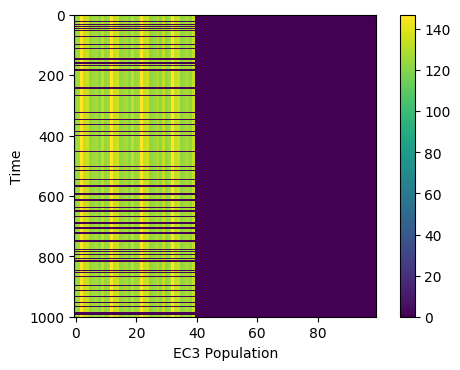

In [174]:


EC3_input = EC3_input_intensity * np.kron(feature_array, np.random.uniform(.8,1, (1,(EC3_size//len(feature_array))))) # rescales the input vector
EC3_input_generated = EC3_input
#map(np.random.shuffle,EC3_input) # we just need to remove this to make the inputs deterministic

matrix = np.zeros((1000,100))
EC3_input = np.repeat(EC3_input,800,axis=0) # full duration EC3 input array



matrix[0:800, 0:100] = EC3_input
np.random.shuffle(matrix)
pylab.imshow(matrix, aspect=.1)
pylab.ylabel('Time')
pylab.xlabel('EC3 Population')
pylab.colorbar()

EC3_input = matrix
EC3_input = TimedArray(EC3_input*pamp, dt=.6*second )

## CA3 input algorithm
### Samples from a beta distribution

* CA3's activity pattern is always random. Even in the deterministic model. This is because of CA3's role in generating orthogonal vectors. Orthogonal vectors have to be different every time. 

In [175]:
CA3_input_generated = np.zeros(100)

def CA3_vector():
    global CA3_input_generated
    global CA3_size
    global CA3_input_intensity
    ortho_CA3 = np.random.beta(1,3,(1,CA3_size))
    ortho_CA3[0,42:100] = 0
    CA3_input = CA3_input_intensity*ortho_CA3
    CA3_input_generated = CA3_input
    CA3_input = np.broadcast_to(CA3_input,(10000,CA3_size)) # the length of the trial should be a variable here. 
    CA3_input = TimedArray(CA3_input*pamp, dt=100*ms )
    return CA3_input

CA3_input= data['CA3_input_vector']#CA3_vector()
CA3_input = TimedArray(CA3_input*pamp, dt=100*ms )


#CA3 = NeuronGroup(CA3_size, CA3_p_eqs, threshold='v>CA3_theta_reset', reset = CA3_post_spike) #threshold in this model is the peak threshold
#CA3_state = StateMonitor(CA3,('v'), record=True)



In [176]:
sim = Network(collect())
sim.store('all_connected')
sim.store('trial_0')

## GABA Input

In [177]:
CA1_OLM_input = np.zeros(1000)
CA1_OLM_input[:] = 500
CA1_OLM_input = TimedArray(CA1_OLM_input*pamp, dt=100*ms )

# 4. Simulations

## Without CA3

In [20]:

CA3_CA1.active = False
duration = 400*second
sim.run(duration)


INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.04s, trying other methods took 0.10s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_2', using method 'euler' (took 0.07s, trying other methods took 0.13s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_3', using method 'euler' (took 0.02s, trying other methods took 0.09s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.03s, trying other methods took 0.13s). [brian2.stateupdaters.base.method_choice]
WARNING    Group uses a dt of 100. us while TimedArray uses dt of 0.6 s [brian2.input.timedarray]
INFO       No numerical integration method specified for group 'synapses', using method 'euler' (took 0.05s, trying other methods took 0.17s). [

In [21]:
slow_learning = np.asarray(EC3_CA1_state.w[20])

In [22]:
EC3_CA1_weights = np.asarray(EC3_CA1.w)
np.savez('/scratch/sanjay/new_folder/LTP_with_inhibition_without_CA3', EC3_CA1_weights=EC3_CA1_weights,EC3_input_generated=EC3_input_generated , CA3_input_generated=CA3_input_generated, slow_learning =slow_learning )

sim.store('After familiarization 10 mins')


#store(state_name, file_name)

In [23]:
#sim.restore('trial_9')

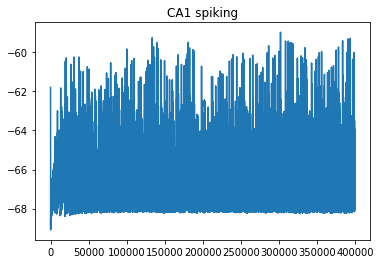

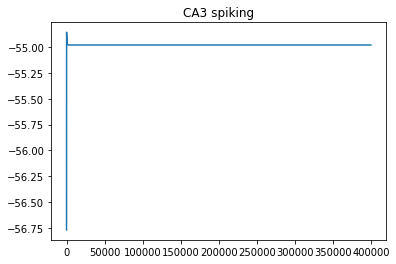

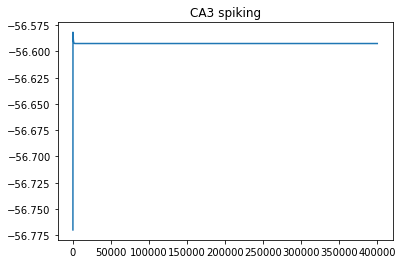

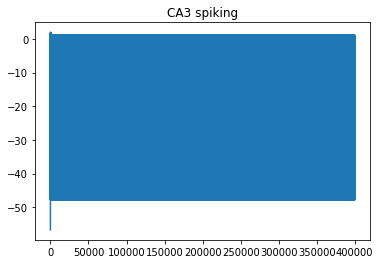

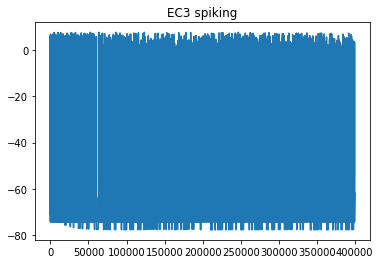

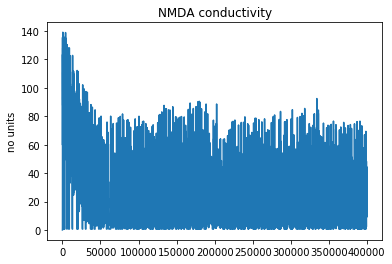

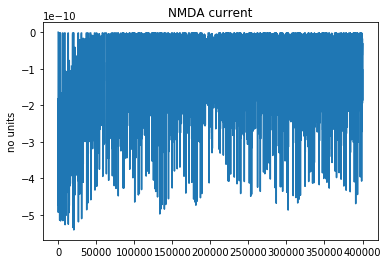

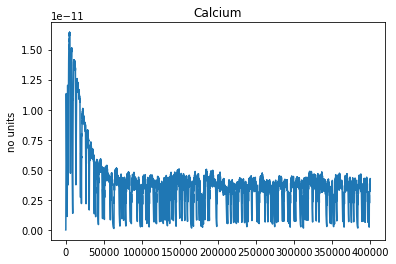

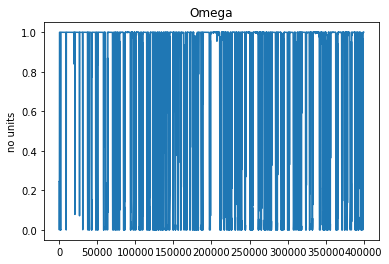

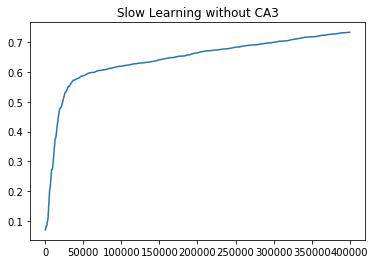

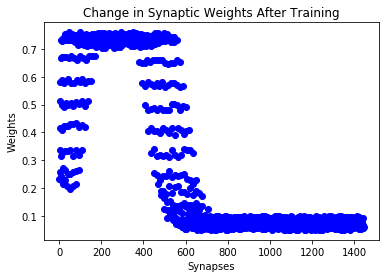

In [24]:
pylab.plot(CA1_state.t/ms,CA1_state.v[20]/mV)
pylab.title('CA1 spiking')
pylab.show()

pylab.plot(CA3_state.t/ms,CA3_state.v[1]/mV)
pylab.title('CA3 spiking')
pylab.show()

pylab.plot(CA3_state.t/ms,CA3_state.v[3]/mV)
pylab.title('CA3 spiking')
pylab.show()


pylab.plot(CA3_state.t/ms,CA3_state.v[6]/mV)
pylab.title('CA3 spiking')
pylab.show()


pylab.plot(EC3_state.t/ms,EC3_state.v[1]/mV)
pylab.title('EC3 spiking')
pylab.show()

#pylab.plot(CA1_state.t/ms,CA1_state.g_syn_EC3[5]/nS)
#pylab.title('Synaptic conductivity at EC3-CA1 synapse')
#pylab.ylabel('conductivity (nS)')
#pylab.show()

pylab.plot(CA1_state.t/ms,(CA1_state.NMDA_g_syn[15]/nS))
pylab.title('NMDA conductivity')
pylab.ylabel('no units')
pylab.show()

pylab.plot(CA1_state.t/ms,(CA1_state.I_NMDA[20]))
pylab.title('NMDA current')
pylab.ylabel('no units')
pylab.show()

pylab.plot(EC3_CA1_state.t/ms,(EC3_CA1_state.Ca[20]))
pylab.title('Calcium')
pylab.ylabel('no units')
pylab.show()

pylab.plot(EC3_CA1_state.t/ms,(EC3_CA1_state.Omega[20]))
pylab.title('Omega')
pylab.ylabel('no units')
pylab.show()

pylab.plot(EC3_CA1_state.t/ms,(EC3_CA1_state.w[20]))
pylab.title('Slow Learning without CA3')
pylab.ylabel('')
pylab.show()


pylab.plot((np.arange(1,len(EC3_CA1.w)+1,1)), EC3_CA1.w[:], 'bo')
pylab.title('Change in Synaptic Weights After Training')
pylab.xlabel("Synapses")
pylab.ylabel('Weights')

#pylab.plot(EC3_CA1_state.t, EC3_CA1_state.w[200])
#pylab.title('Example EC3 Synapse - Change in Synaptic strength')
#pylab.show()



## Let's Look at CA1 representations after learning

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_2', using method 'euler' (took 0.05s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_3', using method 'euler' (took 0.02s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses', using method 'euler' (took 0.04s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]


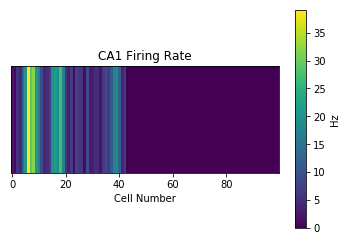

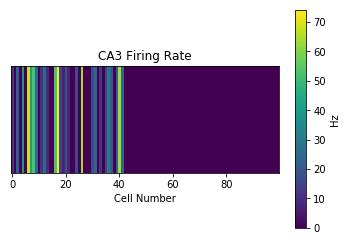

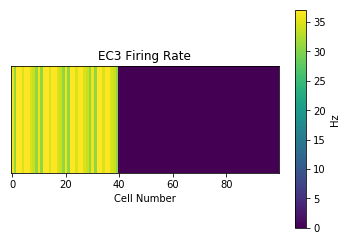

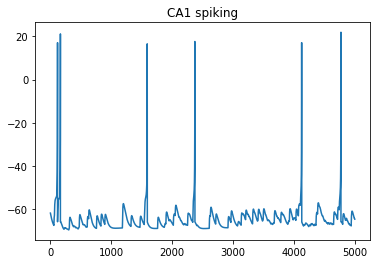

In [25]:
#data = np.load('LTP_with_inhibition.npz')
#EC3_CA1_weights = data['EC3_CA1_weights'] 
#print EC3_CA1_weights

EC3_CA1_weights = EC3_CA1.w # save the weights
sim.restore('all_connected') # reset clock

EC3_CA1.w = EC3_CA1_weights # restore weights

#CA3_input = data['CA3_input_generated']
#EC3_input = data['EC3_input_generated']


#CA3_input = np.broadcast_to(CA3_input,(10000,CA3_size)) # the length of the trial should be a variable here. 
#CA3_input = TimedArray(CA3_input*pamp, dt=100*ms )
#EC3_input = np.repeat(EC3_input,800,axis=0)
#EC3_input = TimedArray(EC3_input*pamp, dt=.6*second )


CA3_CA1.active = True
CA1_GABA.active = False
CA1_OLM.active = True
EC3_CA1.active = True
sim.run(5*second)


CA1_heatmap = np.broadcast_to(np.asarray(CA1_spikes.count), (2, 100) )
CA3_heatmap = np.broadcast_to(np.asarray(CA3_spikes.count), (2, 100) )
EC3_heatmap = np.broadcast_to(np.asarray(EC3_spikes.count), (2, 100) )

pylab.imshow(CA1_heatmap, aspect=20)
pylab.xlabel('Cell Number')
pylab.ylabel('')
pylab.yticks([])
pylab.title('CA1 Firing Rate')
pylab.colorbar(label='Hz')
pylab.show()

pylab.imshow(CA3_heatmap, aspect=20)
pylab.xlabel('Cell Number')
pylab.ylabel('')
pylab.yticks([])
pylab.title('CA3 Firing Rate')
pylab.colorbar(label='Hz')
pylab.show()

pylab.imshow(EC3_heatmap, aspect=20)
pylab.xlabel('Cell Number')
pylab.ylabel('')
pylab.yticks([])
pylab.title('EC3 Firing Rate')
pylab.colorbar(label='Hz')
pylab.show()

pylab.plot(CA1_state.t/ms,CA1_state.v[20]/mV)
pylab.title('CA1 spiking')
pylab.show()


## Sparseness Measure

In [26]:
from __future__ import division

def sparseness(rates):
    '''This code implements the K4 (normalized kurtosis) sparseness measure. Check this paper:
    Hurley, N., & Rickard, S. (2009). Comparing measures of sparsity. 
    IEEE Transactions on Information Theory, 55(10), 4723-4741.
    '''
    numerator = 0
    denominator = 0
    #sparse = -(np.sum(log(1+(rates**2))))
    
    for i in range(0,len(rates),1):
        a = rates[i]**4
        numerator += a
        
        b = rates[i]**2
        denominator += b
        
    sparse = numerator/(denominator**2)
                
    return sparse
    




In [27]:

#rates = rates/rates.max()

rates = np.asarray(EC3_spikes.count)
#rates = rates/rates.max()
print 'Sparseness in EC3 is {}' .format(sparseness(rates[0:41]))
rates = np.asarray(CA1_spikes.count)
print 'Sparseness in CA1 is {} '.format(sparseness(rates[0:41]))
rates = np.asarray(CA3_spikes.count)
#rates = rates/rates.max()
print 'Sparseness in CA3 is {}' .format(sparseness(rates[0:41]))


Sparseness in EC3 is 0.0253831846123
Sparseness in CA1 is 0.0799022804676 
Sparseness in CA3 is 0.0984606331047


# With CA3

In [28]:
CA3_CA1.active = True
duration = 400*second
sim.run(duration)


INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_2', using method 'euler' (took 0.05s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_3', using method 'euler' (took 0.02s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses', using method 'euler' (took 0.04s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]


In [29]:
fast_learning = np.asarray(EC3_CA1_state.w[20])
EC3_CA1_weights = np.asarray(EC3_CA1.w)
np.savez('/scratch/sanjay/new_folder/LTP_with_inhibition_with_CA3', EC3_CA1_weights=EC3_CA1_weights,EC3_input_generated=EC3_input_generated , CA3_input_generated=CA3_input_generated, fast_learning =fast_learning )


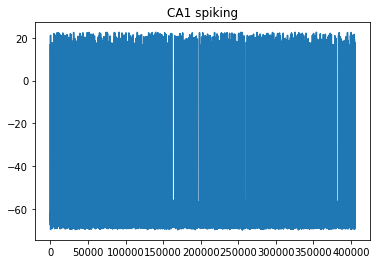

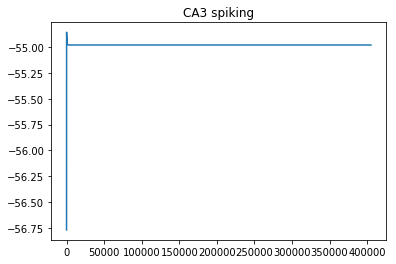

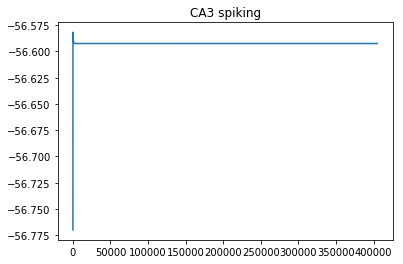

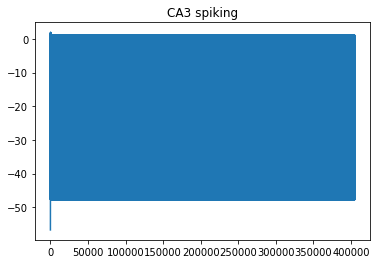

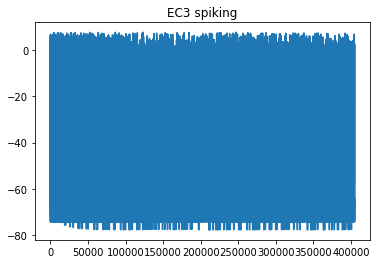

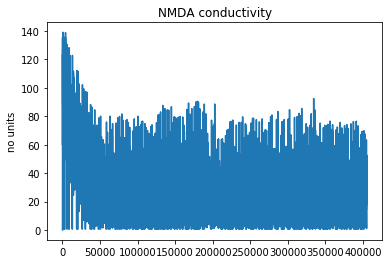

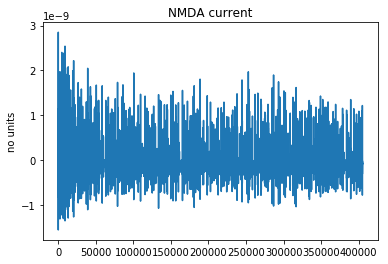

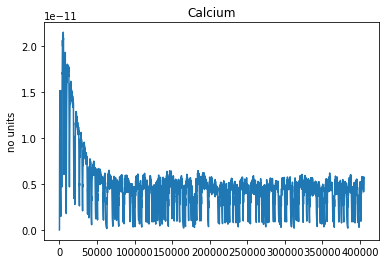

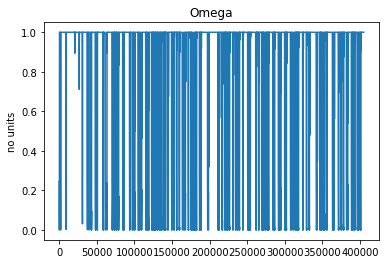

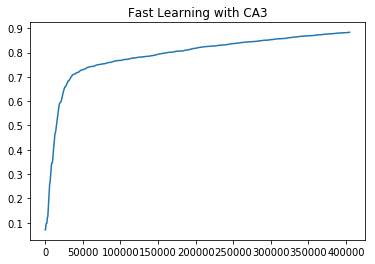

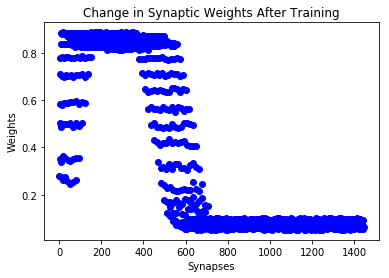

In [30]:
pylab.plot(CA1_state.t/ms,CA1_state.v[20]/mV)
pylab.title('CA1 spiking')
pylab.show()

pylab.plot(CA3_state.t/ms,CA3_state.v[1]/mV)
pylab.title('CA3 spiking')
pylab.show()

pylab.plot(CA3_state.t/ms,CA3_state.v[3]/mV)
pylab.title('CA3 spiking')
pylab.show()


pylab.plot(CA3_state.t/ms,CA3_state.v[6]/mV)
pylab.title('CA3 spiking')
pylab.show()


pylab.plot(EC3_state.t/ms,EC3_state.v[1]/mV)
pylab.title('EC3 spiking')
pylab.show()

#pylab.plot(CA1_state.t/ms,CA1_state.g_syn_EC3[5]/nS)
#pylab.title('Synaptic conductivity at EC3-CA1 synapse')
#pylab.ylabel('conductivity (nS)')
#pylab.show()

pylab.plot(CA1_state.t/ms,(CA1_state.NMDA_g_syn[15]/nS))
pylab.title('NMDA conductivity')
pylab.ylabel('no units')
pylab.show()

pylab.plot(CA1_state.t/ms,(CA1_state.I_NMDA[20]))
pylab.title('NMDA current')
pylab.ylabel('no units')
pylab.show()

pylab.plot(EC3_CA1_state.t/ms,(EC3_CA1_state.Ca[20]))
pylab.title('Calcium')
pylab.ylabel('no units')
pylab.show()

pylab.plot(EC3_CA1_state.t/ms,(EC3_CA1_state.Omega[20]))
pylab.title('Omega')
pylab.ylabel('no units')
pylab.show()

pylab.plot(EC3_CA1_state.t/ms,(EC3_CA1_state.w[20]))
pylab.title('Fast Learning with CA3')
pylab.ylabel('')
pylab.show()


pylab.plot((np.arange(1,len(EC3_CA1.w)+1,1)), EC3_CA1.w[:], 'bo')
pylab.title('Change in Synaptic Weights After Training')
pylab.xlabel("Synapses")
pylab.ylabel('Weights')

#pylab.plot(EC3_CA1_state.t, EC3_CA1_state.w[200])
#pylab.title('Example EC3 Synapse - Change in Synaptic strength')
#pylab.show()


INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_2', using method 'euler' (took 0.05s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_3', using method 'euler' (took 0.02s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses', using method 'euler' (took 0.04s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]


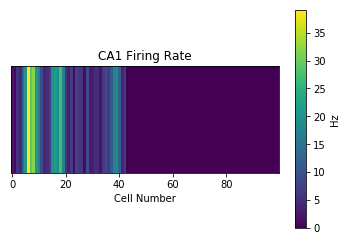

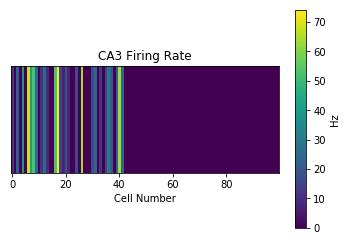

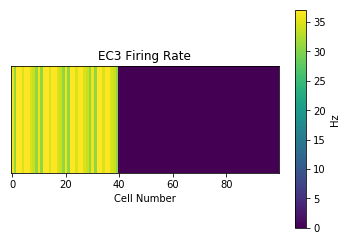

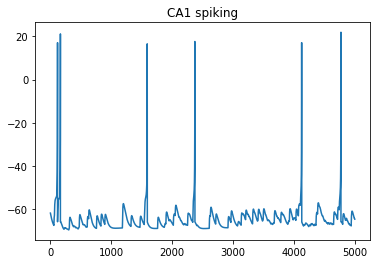

In [31]:
#data = np.load('LTP_with_inhibition.npz')
#EC3_CA1_weights = data['EC3_CA1_weights'] 
#print EC3_CA1_weights

EC3_CA1_weights = EC3_CA1.w # save the weights
sim.restore('all_connected') # reset clock

EC3_CA1.w = EC3_CA1_weights # restore weights

#CA3_input = data['CA3_input_generated']
#EC3_input = data['EC3_input_generated']


#CA3_input = np.broadcast_to(CA3_input,(10000,CA3_size)) # the length of the trial should be a variable here. 
#CA3_input = TimedArray(CA3_input*pamp, dt=100*ms )
#EC3_input = np.repeat(EC3_input,800,axis=0)
#EC3_input = TimedArray(EC3_input*pamp, dt=.6*second )


CA3_CA1.active = True
CA1_GABA.active = False
CA1_OLM.active = True
EC3_CA1.active = True
sim.run(5*second)


CA1_heatmap = np.broadcast_to(np.asarray(CA1_spikes.count), (2, 100) )
CA3_heatmap = np.broadcast_to(np.asarray(CA3_spikes.count), (2, 100) )
EC3_heatmap = np.broadcast_to(np.asarray(EC3_spikes.count), (2, 100) )

pylab.imshow(CA1_heatmap, aspect=20)
pylab.xlabel('Cell Number')
pylab.ylabel('')
pylab.yticks([])
pylab.title('CA1 Firing Rate')
pylab.colorbar(label='Hz')
pylab.show()

pylab.imshow(CA3_heatmap, aspect=20)
pylab.xlabel('Cell Number')
pylab.ylabel('')
pylab.yticks([])
pylab.title('CA3 Firing Rate')
pylab.colorbar(label='Hz')
pylab.show()

pylab.imshow(EC3_heatmap, aspect=20)
pylab.xlabel('Cell Number')
pylab.ylabel('')
pylab.yticks([])
pylab.title('EC3 Firing Rate')
pylab.colorbar(label='Hz')
pylab.show()

pylab.plot(CA1_state.t/ms,CA1_state.v[20]/mV)
pylab.title('CA1 spiking')
pylab.show()

In [110]:
# a test for calcium based Omega function

calcium_input =  np.linspace(0,3,100) #* 1e-6 
B_2 = 80
B_1 = 80
alpha_2 = 1.50#.25
alpha_1 = 1.30#.05




def Omega(Cal):
    global B_1
    global B_2
    global alpha_1
    global alpha_2
    a = .25 + (exp(B_2*(Cal-alpha_2))/(1+exp(B_2*(Cal-alpha_2)))) - ((.25*exp(B_1*(Cal-alpha_1)))/(1+exp(B_1*(Cal-alpha_1))))
    return a
omega_vector = map(Omega, calcium_input)

#P1 = 3

def learning_rate(Ca):
    global P1
    tau_n = P1/((P1/(1e4)) + Ca**3) + 1 
    a = 1/tau_n
    return a

learning_vector = map(learning_rate, calcium_input)

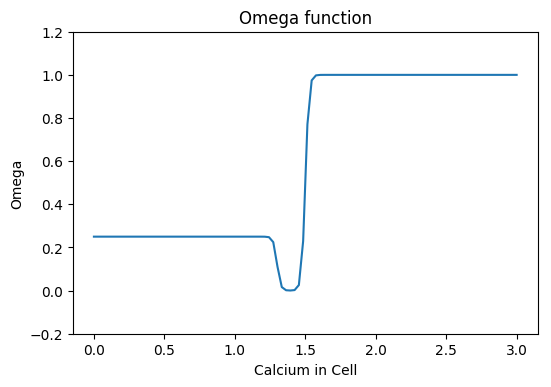

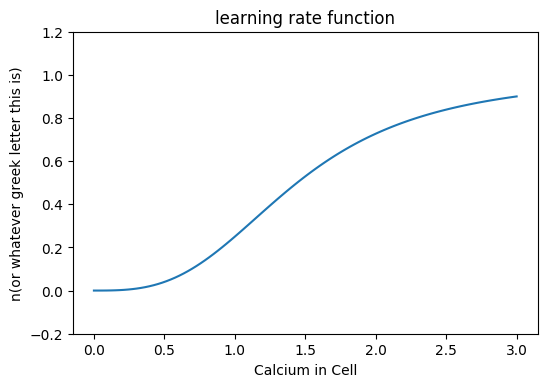

In [111]:
pylab.plot(calcium_input,omega_vector)
pylab.title('Omega function')
pylab.xlabel('Calcium in Cell')
pylab.ylabel('Omega')
pylab.ylim(-.2,1.2)
pylab.show()

pylab.plot(calcium_input,learning_vector)
pylab.title('learning rate function')
pylab.xlabel('Calcium in Cell')
pylab.ylabel('n(or whatever greek letter this is)')
pylab.ylim(-.2,1.2)
pylab.show()

In [34]:
2**3

8

In [35]:
#sim.run(1*second)

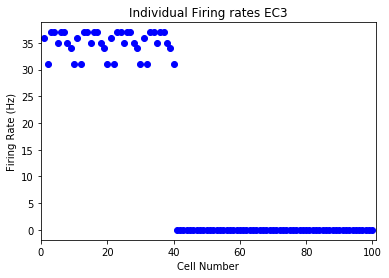

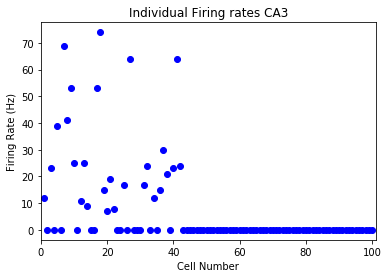

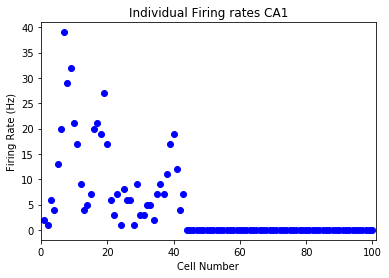

In [36]:
pylab.plot(range(1,len(EC3_spikes.count)+1),EC3_spikes.count, 'bo')

pylab.title('Individual Firing rates EC3')
pylab.xlabel('Cell Number')
pylab.ylabel('Firing Rate (Hz)')
pylab.xlim(0,EC3_size+1)
#pylab.ylim(0,50)
pylab.show()

pylab.plot(range(1,len(CA3_spikes.count)+1),CA3_spikes.count, 'bo')
pylab.title('Individual Firing rates CA3')
pylab.xlabel('Cell Number')
pylab.ylabel('Firing Rate (Hz)')
pylab.xlim(0,CA3_size+1)
#pylab.ylim(0,50)
pylab.show()

pylab.plot(range(1,len(CA1_spikes.count)+1),CA1_spikes.count, 'bo')
pylab.title('Individual Firing rates CA1')
pylab.xlabel('Cell Number')
pylab.ylabel('Firing Rate (Hz)')
pylab.xlim(0,CA1_size+1)
#pylab.ylim(0,50)
pylab.show()

In [92]:
data = np.load('LTP_with_inhibition_with_CA3.npz')
data_2 = np.load('LTP_with_inhibition_without_CA3.npz')

In [99]:
fast_learning = data['fast_learning']
slow_learning = data_2['slow_learning']
len(fast_learning)
critical_weight = np.zeros(len(fast_learning))
critical_weight[:] = .67

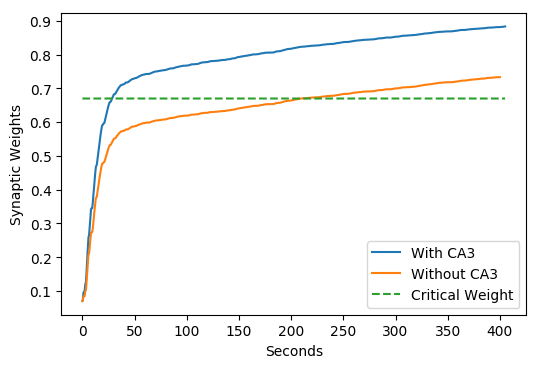

In [107]:
pylab.plot(np.arange(0,405000,1)/1000, fast_learning, label = 'With CA3')
pylab.plot(np.arange(0,len(slow_learning),1)/1000,slow_learning,label = 'Without CA3')
pylab.plot(np.arange(0,len(fast_learning),1)/1000, critical_weight,'--', label = 'Critical Weight')
pylab.xlabel('Seconds')
pylab.ylabel('Synaptic Weights')
pylab.legend()

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_2', using method 'euler' (took 0.05s, trying other methods took 0.08s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_3', using method 'euler' (took 0.02s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses', using method 'euler' (took 0.03s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for 

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


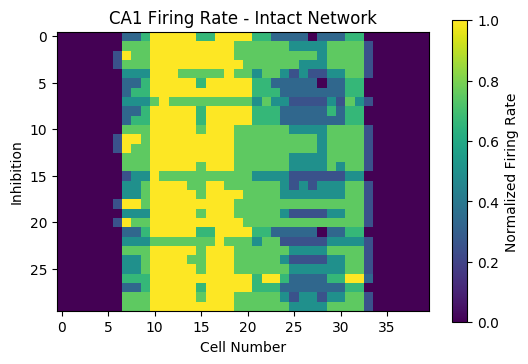

In [44]:
inhibition_results = np.zeros((30,100))


data = np.load('inhibition_sparsity_simulation_intact.npz') #/scratch/sanjay/new_folder/
EC3_weights = data['EC3_weights']

from __future__ import division

for i in range(0,30,1):
    
    EC3_weights = data['EC3_weights']
    
    sim.restore('all_connected')
    
    CA1_GABA.namespace['GABA_jump'] =  10*nS
    CA1_GABA.active = False
    CA3_CA1.active = False
    EC3_CA1.w = EC3_weights[i,:]
    sim.run(2*second)
    inhibition_results[i,:] = np.asarray(CA1_spikes.count)



inhibition_results_normalized = np.zeros((30,100))
for i in range (0,len(inhibition_results), 1):
    inhibition_results_normalized[i,:]= inhibition_results[i,:]/np.max(inhibition_results[i,:])
                
                
print inhibition_results_normalized

pylab.imshow(inhibition_results_normalized[:,0:40], aspect=1)
pylab.xlabel('Cell Number')
pylab.ylabel('Inhibition')
#pylab.yticks([])
pylab.title('CA1 Firing Rate - Intact Network')
pylab.colorbar(label='Normalized Firing Rate')
pylab.show()


In [47]:
len(data['CA3_input_vector'])

10000

INFO       No numerical integration method specified for group 'neurongroup_4', using method 'euler' (took 0.02s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_5', using method 'euler' (took 0.02s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_6', using method 'euler' (took 0.05s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_7', using method 'euler' (took 0.02s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'euler' (took 0.03s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified 

[[ 0.42307692  0.19230769  0.15384615 ...,  0.          0.          0.        ]
 [ 0.40740741  0.18518519  0.18518519 ...,  0.          0.          0.        ]
 [ 0.40740741  0.18518519  0.18518519 ...,  0.          0.          0.        ]
 ..., 
 [ 0.42307692  0.19230769  0.15384615 ...,  0.          0.          0.        ]
 [ 0.40740741  0.18518519  0.18518519 ...,  0.          0.          0.        ]
 [ 0.40740741  0.18518519  0.18518519 ...,  0.          0.          0.        ]]


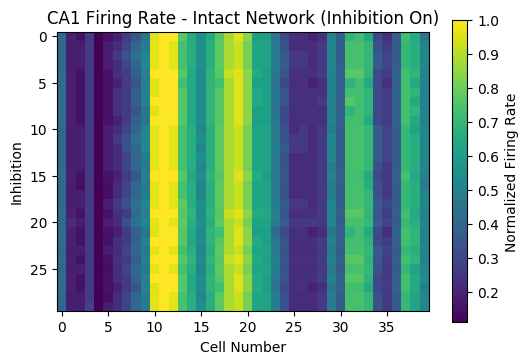

sparseness is 0.0424842217726


In [69]:
inhibition_results = np.zeros((30,100))


data = np.load('inhibition_sparsity_simulation_intact.npz') #/scratch/sanjay/new_folder/
EC3_weights = data['EC3_weights']

from __future__ import division

for i in range(0,30,1):
    
    EC3_weights = data['EC3_weights']
    
    sim.restore('all_connected')
    
    CA1_GABA.namespace['GABA_jump'] =  5*nS
    CA1_GABA.active = True
    CA3_CA1.active = True
    EC3_CA1.w = EC3_weights[i,:]
    sim.run(2*second)
    inhibition_results[i,:] = np.asarray(CA1_spikes.count)



inhibition_results_normalized = np.zeros((30,100))
for i in range (0,len(inhibition_results), 1):
    inhibition_results_normalized[i,:]= inhibition_results[i,:]/np.max(inhibition_results[i,:])
                
                
print inhibition_results_normalized

pylab.imshow(inhibition_results_normalized[:,0:40], aspect=1)
pylab.xlabel('Cell Number')
pylab.ylabel('Inhibition')
#pylab.yticks([])
pylab.title('CA1 Firing Rate - Intact Network (Inhibition On)')
pylab.colorbar(label='Normalized Firing Rate')
pylab.show()

print 'sparseness is {}' .format(sparseness(inhibition_results_normalized[10, :]))

INFO       No numerical integration method specified for group 'neurongroup_4', using method 'euler' (took 0.02s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_5', using method 'euler' (took 0.02s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_6', using method 'euler' (took 0.05s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_7', using method 'euler' (took 0.02s, trying other methods took 0.06s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'euler' (took 0.03s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
WARNING    The name "GABA_jump" refers to different o

[[ 0.36666667  0.26666667  0.26666667 ...,  0.          0.          0.        ]
 [ 0.36666667  0.26666667  0.26666667 ...,  0.          0.          0.        ]
 [ 0.36666667  0.26666667  0.26666667 ...,  0.          0.          0.        ]
 ..., 
 [ 1.          0.09090909  0.09090909 ...,  0.          0.          0.        ]
 [ 1.          0.09090909  0.09090909 ...,  0.          0.          0.        ]
 [ 1.          0.09090909  0.09090909 ...,  0.          0.          0.        ]]


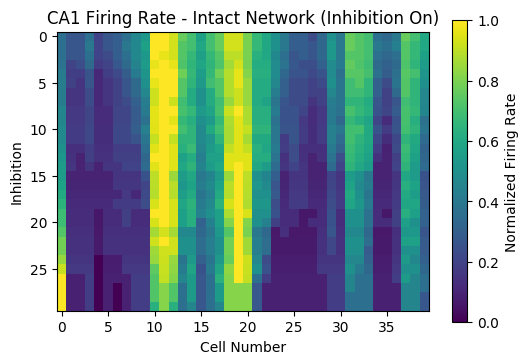

sparseness is 0.0481952132714


In [71]:
inhibition_results = np.zeros((30,100))


data = np.load('inhibition_sparsity_simulation_intact.npz') #/scratch/sanjay/new_folder/
EC3_weights = data['EC3_weights']

from __future__ import division

for i in range(0,30,1):
    
    EC3_weights = data['EC3_weights']
    
    sim.restore('all_connected')
    
    CA1_GABA.namespace['GABA_jump'] =  i*nS # leaving inhibition in
    CA1_GABA.active = True
    CA3_CA1.active = True
    EC3_CA1.w = EC3_weights[i,:]
    sim.run(2*second)
    inhibition_results[i,:] = np.asarray(CA1_spikes.count)



inhibition_results_normalized = np.zeros((30,100))
for i in range (0,len(inhibition_results), 1):
    inhibition_results_normalized[i,:]= inhibition_results[i,:]/np.max(inhibition_results[i,:])
                
                
print inhibition_results_normalized

pylab.imshow(inhibition_results_normalized[:,0:40], aspect=1)
pylab.xlabel('Cell Number')
pylab.ylabel('Inhibition')
#pylab.yticks([])
pylab.title('CA1 Firing Rate - Intact Network (Inhibition On)')
pylab.colorbar(label='Normalized Firing Rate')
pylab.show()

print 'sparseness is {}' .format(sparseness(inhibition_results_normalized[10, :]))

<function matplotlib.pyplot.show>

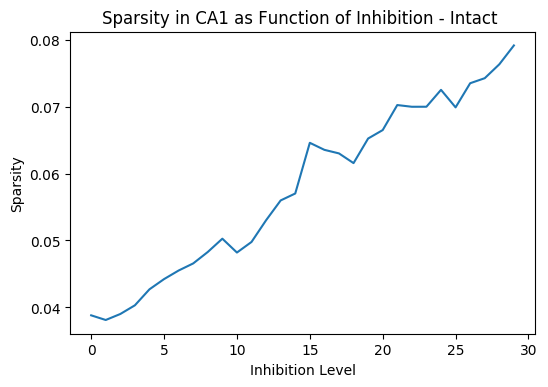

In [72]:
sparsity = np.zeros(len(np.arange(0,30,1)))

for i in np.arange(0,30,1):
    
    sparsity[i]= sparseness(inhibition_results_normalized[i,:])
    

pylab.plot(np.arange(0,len(sparsity),1),sparsity)
#pylab.xlim(0,25)
#pylab.ylim(0,.001)
pylab.title('Sparsity in CA1 as Function of Inhibition - Intact ')
pylab.xlabel('Inhibition Level')
pylab.ylabel('Sparsity')
pylab.show

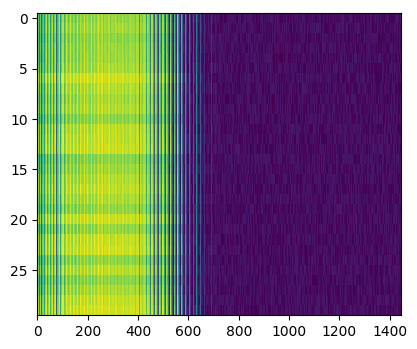

In [38]:
data = np.load('inhibition_sparsity_simulation_intact.npz') #/scratch/sanjay/new_folder/
EC3_weights = data['EC3_weights']
pylab.imshow(EC3_weights, aspect=40)

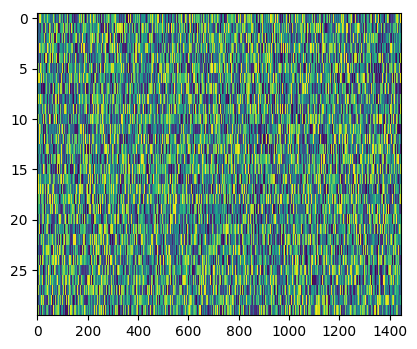

In [41]:
data = np.load('inhibition_sparsity_simulation_CA3_only.npz') #/scratch/sanjay/new_folder/
EC3_weights = data['EC3_weights']
pylab.imshow(EC3_weights, aspect=40)

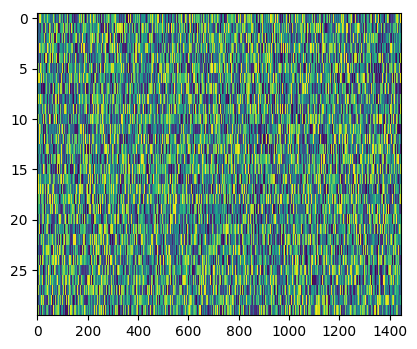

In [42]:
data = np.load('inhibition_sparsity_simulation_EC3_only.npz') #/scratch/sanjay/new_folder/
EC3_weights = data['EC3_weights']
pylab.imshow(EC3_weights, aspect=40)

<function matplotlib.pyplot.show>

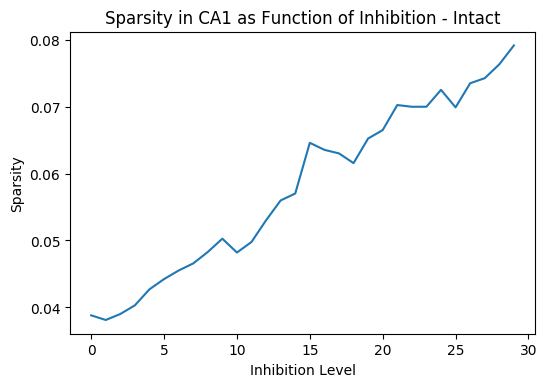

In [90]:
from __future__ import division

def sparseness(rates):
    '''This code implements the K4 (normalized kurtosis) sparseness measure. Check this paper:
    Hurley, N., & Rickard, S. (2009). Comparing measures of sparsity. 
    IEEE Transactions on Information Theory, 55(10), 4723-4741.
    '''
    numerator = 0
    denominator = 0
    #sparse = -(np.sum(log(1+(rates**2))))
    
    for i in range(0,len(rates),1):
        a = rates[i]**4
        numerator += a
        
        b = rates[i]**2
        denominator += b
        
    sparse = numerator/(denominator**2)
                
    return sparse
    


sparsity = np.zeros(len(np.arange(0,30,1)))

for i in np.arange(0,30,1):
    
    sparsity[i]= sparseness(inhibition_results[i,:])
    

pylab.plot(np.arange(0,len(sparsity),1),sparsity)
#pylab.xlim(0,25)
#pylab.ylim(0,.001)
pylab.title('Sparsity in CA1 as Function of Inhibition - Intact')
pylab.xlabel('Inhibition Level')
pylab.ylabel('Sparsity')
pylab.show

## Let's just do some tests to see how inhibition affects the growth of weights

### Here we train with 30 nS worth of inhibition

In [178]:
sim.restore('all_connected')

CA1_GABA.namespace['GABA_jump'] =  30*nS
CA1_GABA.active = True
CA3_CA1.active = True
#EC3_CA1.w = EC3_weights[i,:]
sim.run(30*second)


INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.04s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_2', using method 'euler' (took 0.05s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_3', using method 'euler' (took 0.02s, trying other methods took 0.04s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses', using method 'euler' (took 0.04s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]


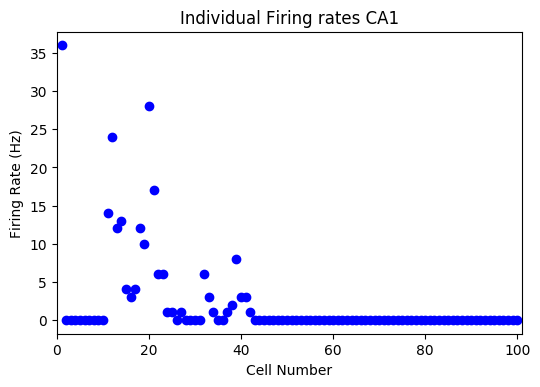

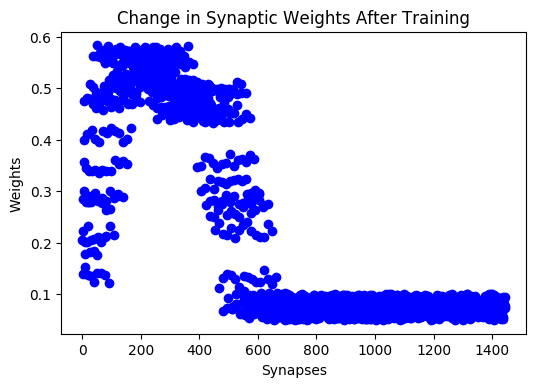

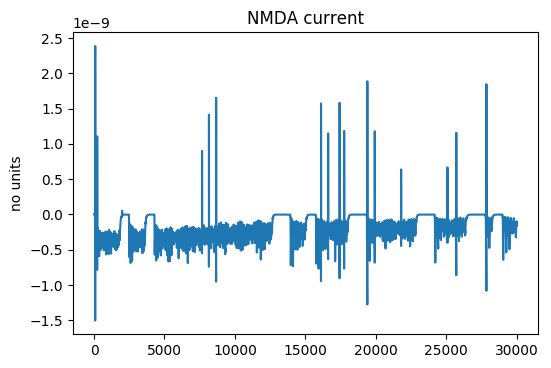

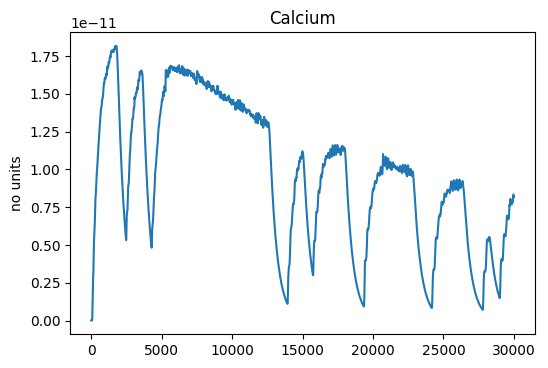

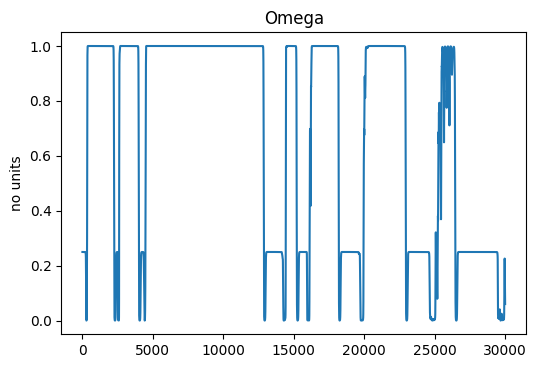

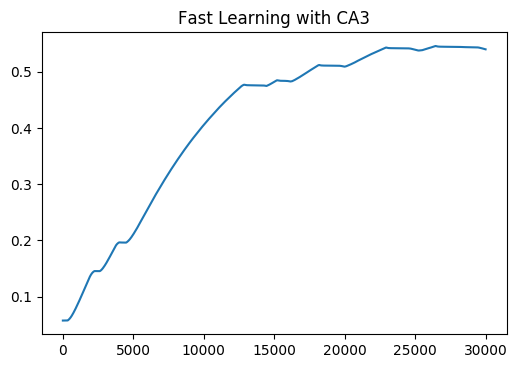

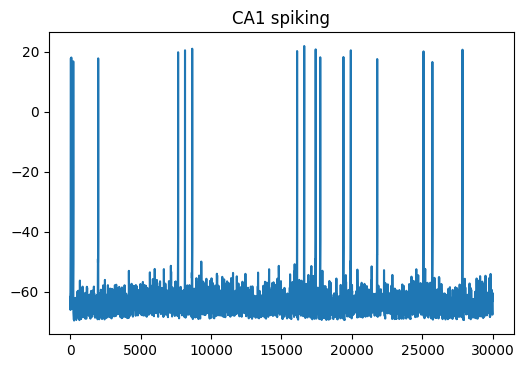

In [179]:
pylab.plot(range(1,len(CA1_spikes.count)+1),CA1_spikes.count, 'bo')
pylab.title('Individual Firing rates CA1')
pylab.xlabel('Cell Number')
pylab.ylabel('Firing Rate (Hz)')
pylab.xlim(0,CA1_size+1)
#pylab.ylim(0,50)
pylab.show()

pylab.plot((np.arange(1,len(EC3_CA1.w)+1,1)), EC3_CA1.w[:], 'bo')
pylab.title('Change in Synaptic Weights After Training')
pylab.xlabel("Synapses")
pylab.ylabel('Weights')
pylab.show()

pylab.plot(CA1_state.t/ms,(CA1_state.I_NMDA[20]))
pylab.title('NMDA current')
pylab.ylabel('no units')
pylab.show()

pylab.plot(EC3_CA1_state.t/ms,(EC3_CA1_state.Ca[20]))
pylab.title('Calcium')
pylab.ylabel('no units')
pylab.show()

pylab.plot(EC3_CA1_state.t/ms,(EC3_CA1_state.Omega[20]))
pylab.title('Omega')
pylab.ylabel('no units')
pylab.show()

pylab.plot(EC3_CA1_state.t/ms,(EC3_CA1_state.w[20]))
pylab.title('Fast Learning with CA3')
pylab.ylabel('')
pylab.show()

pylab.plot(CA1_state.t/ms,CA1_state.v[20]/mV)
pylab.title('CA1 spiking')
pylab.show()



In [180]:
CA1_GABA.namespace['GABA_jump'] =  30*nS
CA1_GABA.active = False
CA3_CA1.active = False
#EC3_CA1.w = EC3_weights[i,:]
sim.run(2*second)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_2', using method 'euler' (took 0.05s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_3', using method 'euler' (took 0.02s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses', using method 'euler' (took 0.04s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]


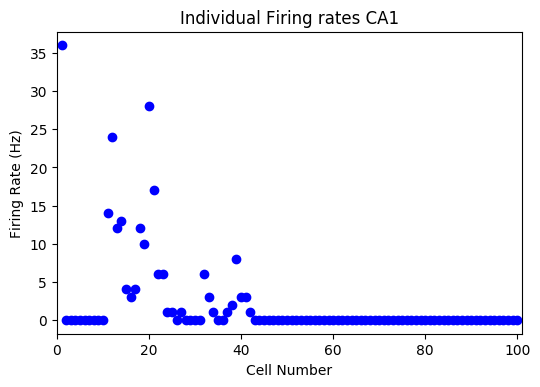

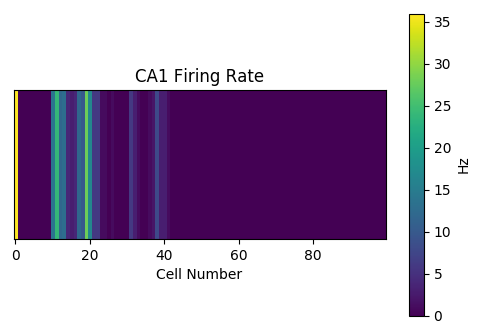

sparseness is 0.182005124368


In [181]:
pylab.plot(range(1,len(CA1_spikes.count)+1),CA1_spikes.count, 'bo')
pylab.title('Individual Firing rates CA1')
pylab.xlabel('Cell Number')
pylab.ylabel('Firing Rate (Hz)')
pylab.xlim(0,CA1_size+1)
#pylab.ylim(0,50)
pylab.show()

CA1_heatmap = np.broadcast_to(np.asarray(CA1_spikes.count), (2, 100) )


pylab.imshow(CA1_heatmap, aspect=20)
pylab.xlabel('Cell Number')
pylab.ylabel('')
pylab.yticks([])
pylab.title('CA1 Firing Rate')
pylab.colorbar(label='Hz')
pylab.show()


print 'sparseness is {}' .format(sparseness(np.asarray(CA1_spikes.count)))

## Let's just do some tests to see how inhibition affects the growth of weights

### Here we train with 5 nS worth of inhibition

In [182]:
sim.restore('all_connected')

CA1_GABA.namespace['GABA_jump'] =  5*nS
CA1_GABA.active = True
CA3_CA1.active = True
#EC3_CA1.w = EC3_weights[i,:]
sim.run(30*second)


INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.01s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_2', using method 'euler' (took 0.05s, trying other methods took 0.08s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_3', using method 'euler' (took 0.01s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses', using method 'euler' (took 0.03s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]


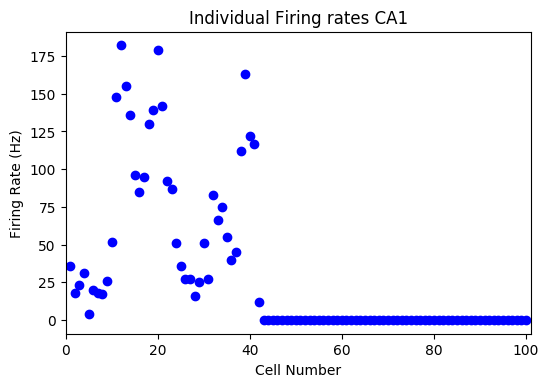

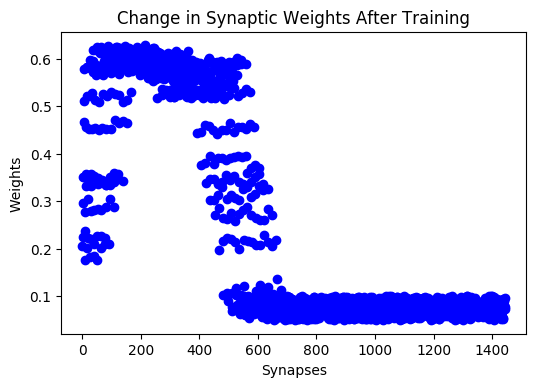

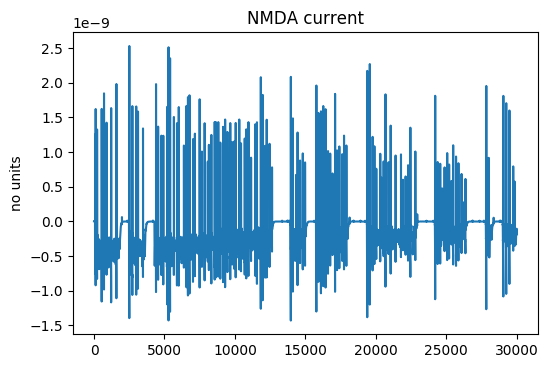

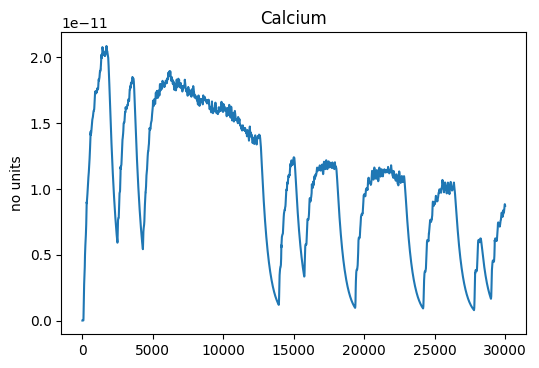

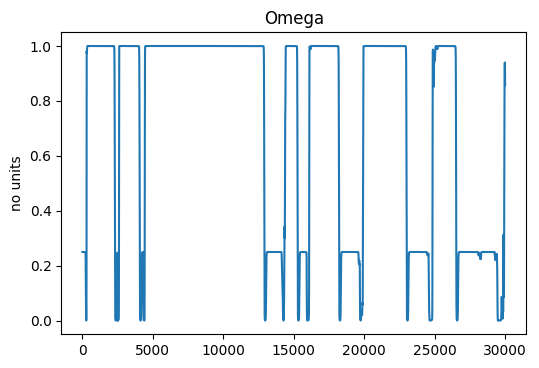

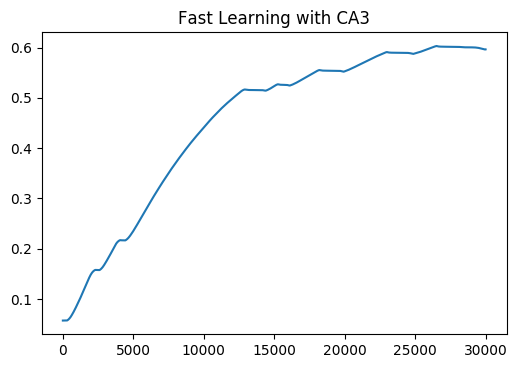

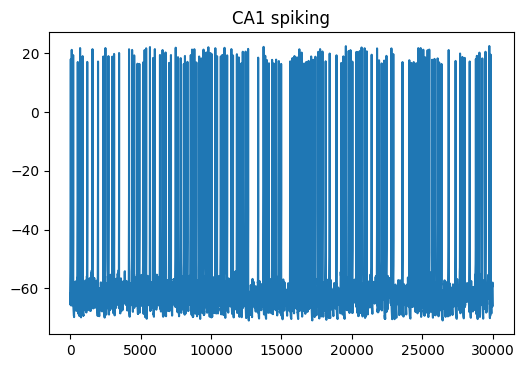

In [183]:
pylab.plot(range(1,len(CA1_spikes.count)+1),CA1_spikes.count, 'bo')
pylab.title('Individual Firing rates CA1')
pylab.xlabel('Cell Number')
pylab.ylabel('Firing Rate (Hz)')
pylab.xlim(0,CA1_size+1)
#pylab.ylim(0,50)
pylab.show()

pylab.plot((np.arange(1,len(EC3_CA1.w)+1,1)), EC3_CA1.w[:], 'bo')
pylab.title('Change in Synaptic Weights After Training')
pylab.xlabel("Synapses")
pylab.ylabel('Weights')
pylab.show()

pylab.plot(CA1_state.t/ms,(CA1_state.I_NMDA[20]))
pylab.title('NMDA current')
pylab.ylabel('no units')
pylab.show()

pylab.plot(EC3_CA1_state.t/ms,(EC3_CA1_state.Ca[20]))
pylab.title('Calcium')
pylab.ylabel('no units')
pylab.show()

pylab.plot(EC3_CA1_state.t/ms,(EC3_CA1_state.Omega[20]))
pylab.title('Omega')
pylab.ylabel('no units')
pylab.show()

pylab.plot(EC3_CA1_state.t/ms,(EC3_CA1_state.w[20]))
pylab.title('Fast Learning with CA3')
pylab.ylabel('')
pylab.show()

pylab.plot(CA1_state.t/ms,CA1_state.v[20]/mV)
pylab.title('CA1 spiking')
pylab.show()



In [184]:
CA1_GABA.namespace['GABA_jump'] =  60*nS
CA1_GABA.active = False
CA3_CA1.active = False
#EC3_CA1.w = EC3_weights[i,:]
sim.run(2*second)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_2', using method 'euler' (took 0.05s, trying other methods took 0.08s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_3', using method 'euler' (took 0.02s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses', using method 'euler' (took 0.04s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]


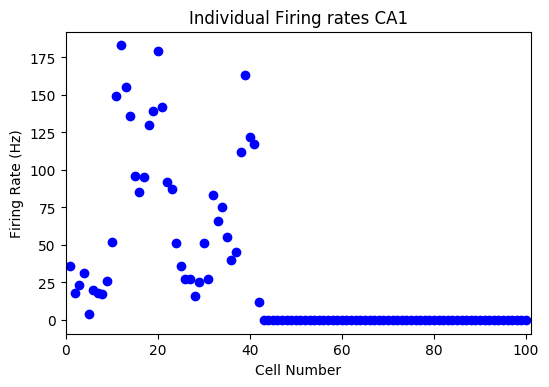

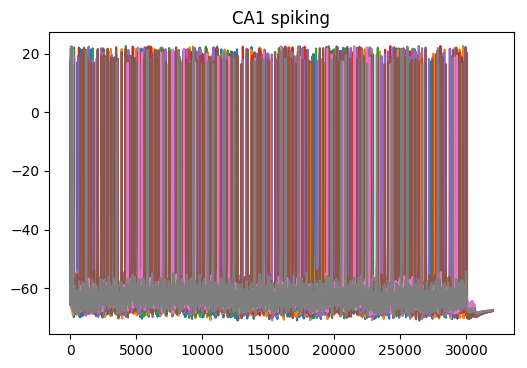

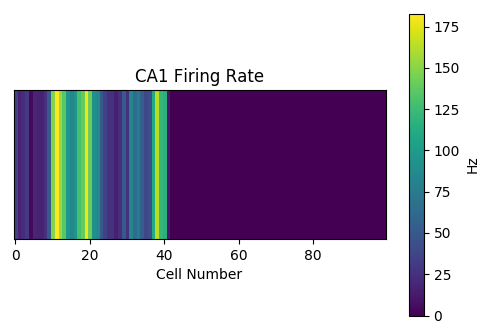

sparseness is 0.0563894239221


In [185]:
pylab.plot(range(1,len(CA1_spikes.count)+1),CA1_spikes.count, 'bo')
pylab.title('Individual Firing rates CA1')
pylab.xlabel('Cell Number')
pylab.ylabel('Firing Rate (Hz)')
pylab.xlim(0,CA1_size+1)
#pylab.ylim(0,50)
pylab.show()

pylab.plot(CA1_state.t/ms,CA1_state.v[20]/mV)
pylab.plot(CA1_state.t/ms,CA1_state.v[18]/mV)
pylab.plot(CA1_state.t/ms,CA1_state.v[16]/mV)

pylab.plot(CA1_state.t/ms,CA1_state.v[14]/mV)
pylab.plot(CA1_state.t/ms,CA1_state.v[13]/mV)
pylab.plot(CA1_state.t/ms,CA1_state.v[10]/mV)
pylab.plot(CA1_state.t/ms,CA1_state.v[8]/mV)
pylab.plot(CA1_state.t/ms,CA1_state.v[3]/mV)

pylab.title('CA1 spiking')
pylab.show()

CA1_heatmap = np.broadcast_to(np.asarray(CA1_spikes.count), (2, 100) )


pylab.imshow(CA1_heatmap, aspect=20)
pylab.xlabel('Cell Number')
pylab.ylabel('')
pylab.yticks([])
pylab.title('CA1 Firing Rate')
pylab.colorbar(label='Hz')
pylab.show()

print 'sparseness is {}' .format(sparseness(np.asarray(CA1_spikes.count)))


In [99]:
print 'sparseness is {}' .format(sparseness(np.asarray(CA1_spikes.count)))

sparseness is 0.0591817264302
